## importing and cleaning the datasets

In [1]:
import networkx  as nx
import pandas as pd
import matplotlib.pyplot as plt

df=pd.read_excel("/Users/matteomedini/Downloads/output_matteo.xlsx")

df= df.rename(columns= {"id1_sensor_age": "age1", "id2_sensor_age": "age2"})
df=df.rename(columns={"id1_sensor_gender":"gender1", "id2_sensor_gender":"gender2"})

# we need age labels to categorize nodes 
def categorize(age):
    if age<11:
        return "children"
    if age <19 and age>=11:
        return "adolescents"
    else:
        return "adults"
    
df["age1"]= df["age1"].apply(categorize)
df["age2"]= df["age2"].apply(categorize)

df=df.rename(columns= {"participant_id": "id1", "participant_id2": "id2"})
df=df.rename(columns= {"contact_day": "day"})
df=df.rename(columns= {"contact_duration": "seconds"})

df['day'] = pd.to_datetime(df['day'])

## intrahousehold contact matrix

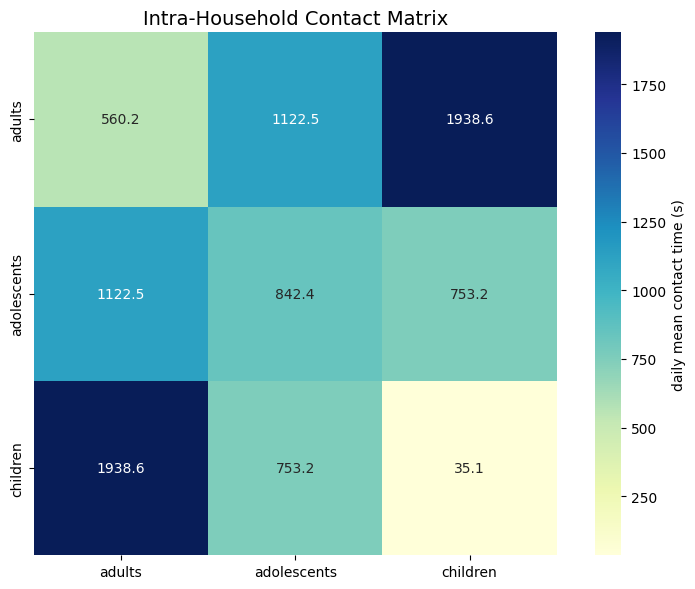

In [2]:
from itertools import combinations
import numpy as np

#get the number of adults, adolescents and children

meta1 = df[['id1', 'age1']].rename(columns={'id1': 'id', 'age1': 'age_group'})
meta2 = df[['id2', 'age2']].rename(columns={'id2': 'id', 'age2': 'age_group'})
all_meta = pd.concat([meta1, meta2]).drop_duplicates(subset='id')

num_adults = (all_meta['age_group'] == 'adults').sum()
num_adolescents = (all_meta['age_group'] == 'adolescents').sum()
num_children = (all_meta['age_group'] == 'children').sum()

# create a participation dataframe to count the number of days each person had at least one contact with anybody(wore the sensor)
df_participation = pd.DataFrame({
    'id': pd.concat([df['id1'], df['id2']]),
    'day': pd.concat([df['day'], df['day']])
}).drop_duplicates()

person_days = df_participation.groupby('id')['day'].apply(set).to_dict()

#adolescents-children
adolescents = all_meta[all_meta['age_group'] == 'adolescents']['id'].unique()
children = all_meta[all_meta['age_group'] == 'children']['id'].unique()
adolescent_days = [len(person_days.get(i, set())) for i in adolescents]
child_days = [len(person_days.get(i, set())) for i in children]


mean_overlap_adolescents_children= np.mean(adolescent_days + child_days)

#adults-adults

adults = all_meta[all_meta['age_group'] == 'adults']['id'].unique()
adult_days = [len(person_days.get(i, set())) for i in adults]
mean_overlap_adults = np.mean(adult_days)

#adults-adolescents
mean_overlap_adults_adolescents= np.mean(adult_days + adolescent_days)

#adults-children
mean_overlap_adults_children= np.mean(adult_days+ child_days)

#adolescents
mean_overlap_adolescents= np.mean(adolescent_days)

#children
mean_overlap_children= np.mean(child_days)



#cell 1 (adults - adults)

total_duration_adults = df[
    (df['household'] == 'intra-household') &
    (df['age1'] == 'adults') &
    (df['age2'] == 'adults')
]['seconds'].sum()

numeratorcellone= total_duration_adults/ mean_overlap_adults

cellone= numeratorcellone/num_adults


#cell 2 (adult-adolescent)

total_duration_adults_adolescents = df[
    (df['household'] == 'intra-household') &
    (((df['age1'] == 'adults') & (df['age2'] == 'adolescents')) |  ((df['age1'] == 'adolescents') & (df['age2'] == 'adults')))
]['seconds'].sum()

numeratorcelltwo= total_duration_adults_adolescents *2/mean_overlap_adults_adolescents
celltwo= numeratorcelltwo/( num_adults+ num_adolescents)

#cell 3 (adult- children)

total_duration_adults_children = df[
    (df['household'] == 'intra-household') &
    (((df['age1'] == 'adults') & (df['age2'] == 'children')) |  ((df['age1'] == 'children') & (df['age2'] == 'adults')))
]['seconds'].sum()

numeratorcellthree= total_duration_adults_children *2/mean_overlap_adults_children
cellthree= numeratorcellthree/( num_adults+ num_children)


#cell4 (adolescent-adolescent)

total_duration_adolescents = df[
    (df['household'] == 'intra-household') &
    (df['age1'] == 'adolescents') &
    (df['age2'] == 'adolescents')
]['seconds'].sum()

numeratorcellfour= total_duration_adolescents/mean_overlap_adolescents

cellfour= numeratorcellfour/num_adolescents

#cell5 (adolescent- children)

total_duration_adolescents_children = df[
    (df['household'] == 'intra-household') &
    (((df['age1'] == 'adolescents') & (df['age2'] == 'children')) |  ((df['age1'] == 'children') & (df['age2'] == 'adolescents')))
]['seconds'].sum()

numeratorcellfive= total_duration_adolescents_children *2/mean_overlap_adolescents_children
cellfive= numeratorcellfive/( num_adolescents+ num_children)

#cell6 (children- children)

total_duration_children = df[
    (df['household'] == 'intra-household') &
    (df['age1'] == 'children') &
    (df['age2'] == 'children')
]['seconds'].sum()

numeratorcellsix= total_duration_children/mean_overlap_children

cellsix= numeratorcellsix/num_children


import matplotlib.pyplot as plt
import seaborn as sns
# draw the matrix

intra_matrix = pd.DataFrame({
    'adults':      [cellone, celltwo, cellthree],
    'adolescents':   [celltwo, cellfour, cellfive],
    'children':        [cellthree, cellfive, cellsix]
}, index=['adults', 'adolescents', 'children'])

plt.figure(figsize=(8, 6))
sns.heatmap(intra_matrix, annot=True, fmt=".1f", cmap="YlGnBu", square=True, cbar_kws={'label': 'daily mean contact time (s)'})

plt.title("Intra-Household Contact Matrix", fontsize=14)
plt.tight_layout()
plt.show()




## interhousehold contact matrix

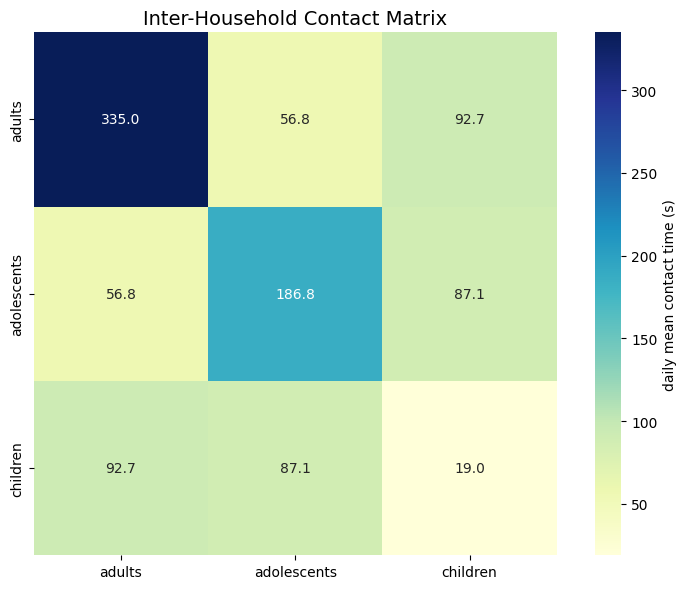

In [114]:
#cell 1 (adults - adults)

total_duration_adultsinter = df[
    (df['household'] == 'inter-household') &
    (df['age1'] == 'adults') &
    (df['age2'] == 'adults')
]['seconds'].sum()

numeratorcelloneinter= total_duration_adultsinter/ mean_overlap_adults

celloneinter= numeratorcelloneinter/num_adults


#cell 2 (adult-adolescent)

total_duration_adults_adolescentsinter = df[
    (df['household'] == 'inter-household') &
    (((df['age1'] == 'adults') & (df['age2'] == 'adolescents')) |  ((df['age1'] == 'adolescents') & (df['age2'] == 'Adults')))
]['seconds'].sum()

numeratorcelltwointer= total_duration_adults_adolescentsinter *2/mean_overlap_adults_adolescents
celltwointer= numeratorcelltwointer/( num_adults+ num_adolescents)

#cell 3 (adult- children)

total_duration_adults_childreninter = df[
    (df['household'] == 'inter-household') &
    (((df['age1'] == 'adults') & (df['age2'] == 'children')) |  ((df['age1'] == 'children') & (df['age2'] == 'adults')))
]['seconds'].sum()

numeratorcellthreeinter= total_duration_adults_childreninter *2/mean_overlap_adults_children
cellthreeinter= numeratorcellthreeinter/( num_adults+ num_children)


#cell4 (adolescent-adolescent)

total_duration_adolescentsinter = df[
    (df['household'] == 'inter-household') &
    (df['age1'] == 'adolescents') &
    (df['age2'] == 'adolescents')
]['seconds'].sum()

numeratorcellfourinter= total_duration_adolescentsinter/mean_overlap_adolescents

cellfourinter= numeratorcellfourinter/num_adolescents

#cell5 (adolescent- children)

total_duration_adolescents_childreninter = df[
    (df['household'] == 'inter-household') &
    (((df['age1'] == 'adolescents') & (df['age2'] == 'children')) |  ((df['age1'] == 'children') & (df['age2'] == 'adolescents')))
]['seconds'].sum()

numeratorcellfiveinter= total_duration_adolescents_childreninter *2/mean_overlap_adolescents_children
cellfiveinter= numeratorcellfiveinter/( num_adolescents+ num_children)

#cell6 (children- children)

total_duration_childreninter = df[
    (df['household'] == 'inter-household') &
    (df['age1'] == 'children') &
    (df['age2'] == 'children')
]['seconds'].sum()

numeratorcellsixinter= total_duration_childreninter/mean_overlap_children

cellsixinter= numeratorcellsixinter/num_children

# drawing the matrix

inter_matrix = pd.DataFrame({
    'adults':      [celloneinter, celltwointer, cellthreeinter],
    'adolescents':   [celltwointer, cellfourinter, cellfiveinter],
    'children':        [cellthreeinter, cellfiveinter, cellsixinter]
}, index=['adults', 'adolescents', 'children'])

plt.figure(figsize=(8, 6))
sns.heatmap(inter_matrix, annot=True, fmt=".1f", cmap="YlGnBu", square=True, cbar_kws={'label': 'daily mean contact time (s)'})

plt.title("Inter-Household Contact Matrix", fontsize=14)
plt.tight_layout()
plt.show()


## weighted network's visual representation

<Figure size 1000x800 with 0 Axes>

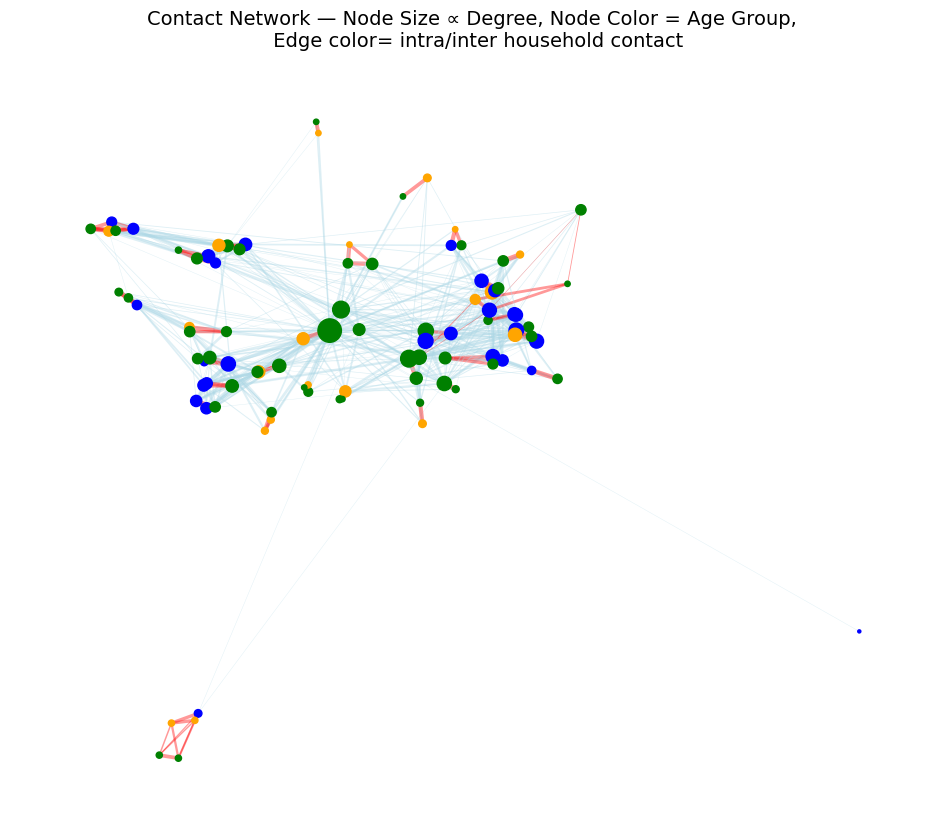

In [119]:
G = nx.Graph()

df['pair'] = df.apply(lambda row: tuple(sorted([row['id1'], row['id2']])), axis=1)
contact_sums = df.groupby('pair')['contact_event'].sum().reset_index()
contact_sums.columns = ['pair', 'weight'] 

for row in contact_sums.itertuples(index=False):
    id1, id2 = row.pair
    weight = row.weight
    G.add_edge(id1, id2, weight=weight)


meta_1 = df[['id1', 'age1']].rename(columns={'id1': 'id', 'age1': 'role'})
meta_2 = df[['id2', 'age2']].rename(columns={'id2': 'id', 'age2': 'role'})
meta_df = pd.concat([meta_1, meta_2]).drop_duplicates(subset='id')
metadata = dict(zip(meta_df['id'], meta_df['role']))

node_sizes = [G.degree(n) * 5 for n in G.nodes()]  
color_map = {'children': 'orange','adolescents': 'blue','adults': 'green'}
node_colors = [color_map.get(metadata.get(n, 'adults'), 'gray') for n in G.nodes()]
weights1 = [np.log(1 + G[u][v]['weight']) / np.log(10) for u, v in G.edges()]
edge_colors = []

for u, v in G.edges():
    row = df[((df['id1'] == u) & (df['id2'] == v)) | ((df['id1'] == v) & (df['id2'] == u))]
    if not row.empty and row.iloc[0]['household'] == 'intra-household':
        edge_colors.append('red')
    else:
        edge_colors.append('lightblue')

pos = nx.spring_layout(G, seed=200)
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, width=weights1, edge_color=edge_colors, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)

plt.title(" Node size is proportional to the degree and the edge width to the aggregated weight\n NODE COLORS : children-yellow, adolescents-blue, adults-green \n EDGE COLORS : intrahousehold-red, interhousehold-blue ", fontsize=8)
plt.axis('off')
plt.show()



## unweighted network visual representation

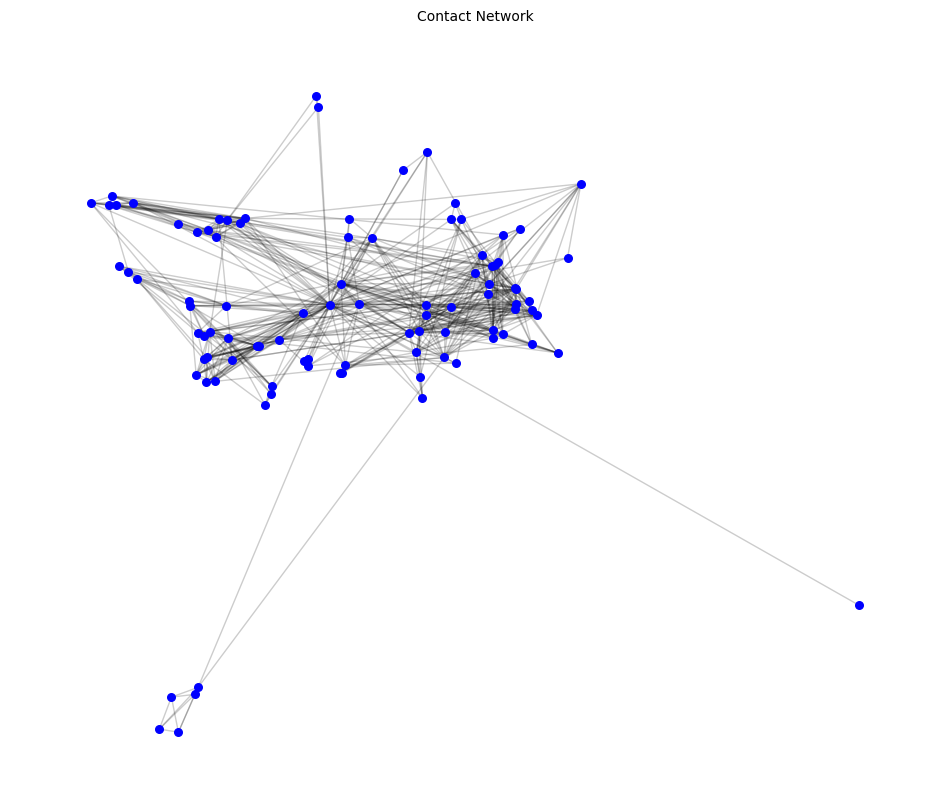

In [130]:
# simple network
pos = nx.spring_layout(G, seed=200)
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos,edge_color="black", alpha=0.2)
nx.draw_networkx_nodes(G, pos,node_size=30, node_color="blue")
plt.title("Contact Network", fontsize=10)
plt.axis('off')
plt.show()


## community detection

### louvain weighted

In [142]:
import community.community_louvain as community_louvain
from sklearn.metrics import normalized_mutual_info_score

weights = [G[u][v].get('weight', 1.0) for u, v in G.edges()]

#the number of true households is 32, which is greater than the square root of 2*|E| for this graph,
#so we need to adjust the resolution parameter to properly run the louvain algorithm. We change it to 2.0 (default is 1.0)
partitionweighted = community_louvain.best_partition(G, weight= "weights",resolution=2.0)
modularity_scoreweighted = community_louvain.modularity(partitionweighted, G) #0.7weighted 

#two dictionaries to be able to compute the NMI score between louvain communities and true household structure
df4 = df[['id1', 'hh_id']].rename(columns={'id1': 'id', 'hh_id': 'hh_id'})
df5 = df[['id2', 'hh_id2']].rename(columns={'id2': 'id', 'hh_id2': 'hh_id'})
hh_df = pd.concat([df4, df5]).drop_duplicates(subset='id')
household_dict = dict(zip(hh_df['id'], hh_df['hh_id']))

# compute NMI
nodes = list(G.nodes())  
true_labels = [household_dict[n] for n in nodes]
pred_labels = [partitionweighted[n] for n in nodes]

nmi = normalized_mutual_info_score(true_labels, pred_labels) 

#the modularity you will print is the modularity score of the graph that was maximized by the algorithm

print(f"Modularity (weighted): {modularity_scoreweighted:.3f}")
print(f"NMI louvain communities - household labels: {nmi:.3f}")
print(f"Number of communities detected: {len(set(partitionweighted.values()))}")


#take into account that this analysis has the goal of understanding how households are structured and if they behave like standard communities in a graph.
#Hence, we are not inferring household memberships ourselves. This applies also for the unweighted version of the algorithm.



Modularity (unweighted): 0.807
NMI with household labels: 0.781
Number of communities detected: 11


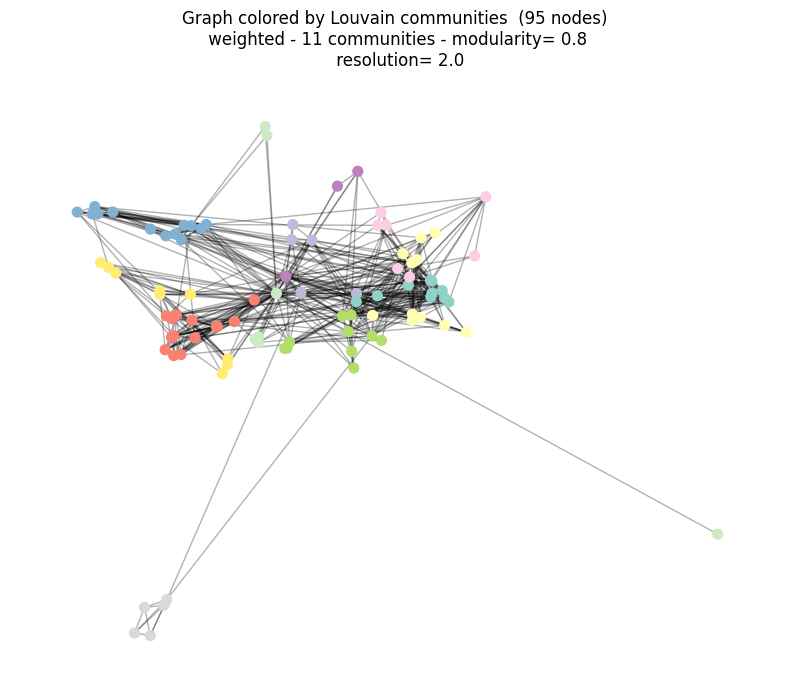

In [144]:
#graph colored by louvain communities
pos = nx.spring_layout(G, seed=200)
community_colors = [partitionweighted[n] for n in G.nodes()]
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=community_colors, cmap=plt.cm.Set3, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Graph colored by Louvain communities  (95 nodes) \n weighted - 11 communities - modularity= 0.8 \n resolution= 2.0")
plt.axis('off')
plt.show()


### louvain unweighted

In [141]:
G_unweighted = nx.Graph()
G_unweighted.add_edges_from(G.edges())  # adds edges without weights
partition_unweighted = community_louvain.best_partition(G_unweighted, resolution=2.0)
modularity_unweighted = community_louvain.modularity(partition_unweighted, G_unweighted)
nodes = list(G_unweighted.nodes())
true_labels = [household_dict[n] for n in nodes]
pred_labels_unweighted = [partition_unweighted[n] for n in nodes]
nmi_unweighted = normalized_mutual_info_score(true_labels, pred_labels_unweighted)

print(f"Modularity (unweighted): {modularity_unweighted:.3f}")
print(f"NMI louvain communities - household labels: {nmi_unweighted:.3f}")
print(f"Number of communities detected: {len(set(partition_unweighted.values()))}")



Modularity (unweighted): 0.403
NMI with household labels: 0.748
Number of communities detected: 10


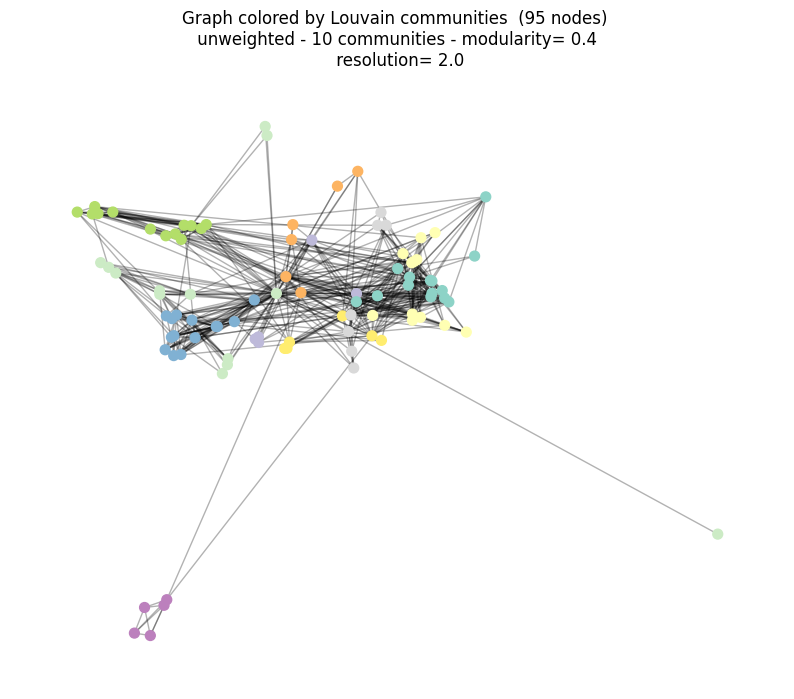

In [145]:
#graph colored by louvain communities
pos = nx.spring_layout(G, seed=200)
community_colors = [partition_unweighted[n] for n in G.nodes()]
plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=community_colors, cmap=plt.cm.Set3, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Graph colored by Louvain communities  (95 nodes) \n unweighted - 10 communities - modularity= 0.4 \n resolution= 2.0")
plt.axis('off')
plt.show()


### household membership visualization

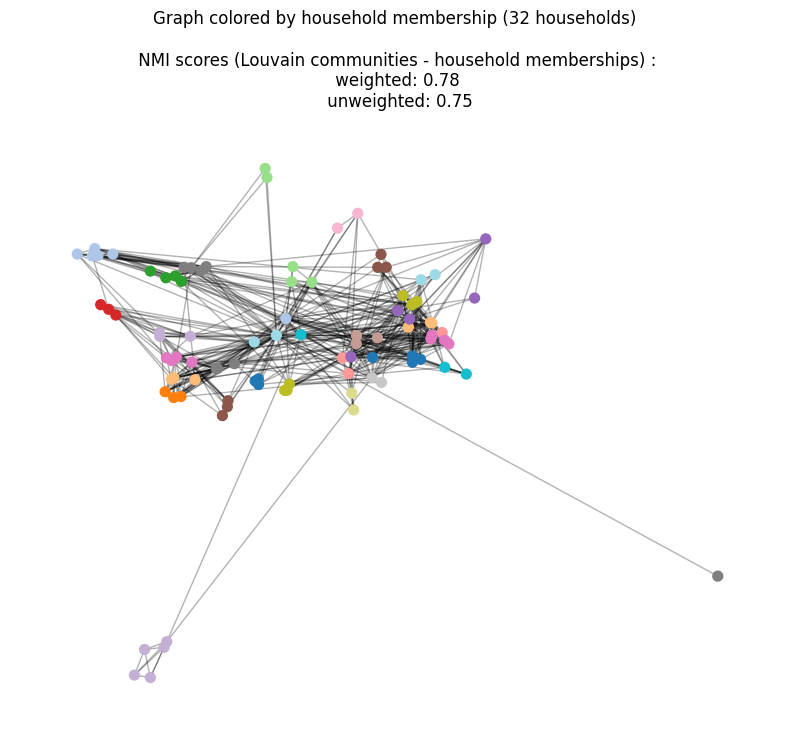

In [147]:
unique_households = list(set(household_dict.values()))
household_to_index = {hh: i for i, hh in enumerate(unique_households)}
indexed_household_colors = [household_to_index[household_dict[n]] for n in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=indexed_household_colors, cmap=plt.cm.tab20, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Graph colored by household membership (32 households) \n NMI scores (Louvain communities - household memberships) : \n weighted: 0.78 \n unweighted: 0.75")
plt.axis('off')
plt.show()



## assortativity

###  Emprical values collection - fraction of contact events between people of same gender and age (intra, inter) 

In [149]:
#UNWEIGHTED empirical values

intra_df_unw = df[df['household'] == 'intra-household']
inter_df_unw = df[df['household'] == 'inter-household']

# Same-gender masks within each group
intra_same_gender_mask_unw = intra_df_unw['gender1'] == intra_df_unw['gender2']
inter_same_gender_mask_unw = inter_df_unw['gender1'] == inter_df_unw['gender2']

# Same-age masks within each group
intra_same_age_mask_unw = intra_df_unw['age1'] == intra_df_unw['age2']
inter_same_age_mask_unw = inter_df_unw['age1'] == inter_df_unw['age2']

#count number of contact pairs
intra_total_unw = len(intra_df_unw)
inter_total_unw = len(inter_df_unw)

# Gender-based fractions (unweighted)
intra_same_gender_unw = intra_same_gender_mask_unw.sum()
inter_same_gender_unw = inter_same_gender_mask_unw.sum()

fraction_intra_gender_unw = intra_same_gender_unw / intra_total_unw #if intra_total_unw > 0 else 0
fraction_inter_gender_unw = inter_same_gender_unw / inter_total_unw 

# Age-based fractions (unweighted)
intra_same_age_unw = intra_same_age_mask_unw.sum()
inter_same_age_unw = inter_same_age_mask_unw.sum()

fraction_intra_age_unw = intra_same_age_unw / intra_total_unw 
fraction_inter_age_unw = inter_same_age_unw / inter_total_unw 



#WEIGHTED empirical values

intra_df = df[df['household'] == 'intra-household']
inter_df = df[df['household'] == 'inter-household']

# Same-gender masks within each group
intra_same_gender_mask = intra_df['gender1'] == intra_df['gender2']
inter_same_gender_mask = inter_df['gender1'] == inter_df['gender2']

# Same-age masks within each group
intra_same_age_mask = intra_df['age1'] == intra_df['age2']
inter_same_age_mask = inter_df['age1'] == inter_df['age2']

# Weighted sums of contact events
intra_total = intra_df['contact_event'].sum()
inter_total = inter_df['contact_event'].sum()

# Gender-based fractions
intra_same_gender = intra_df[intra_same_gender_mask]['contact_event'].sum()
inter_same_gender = inter_df[inter_same_gender_mask]['contact_event'].sum()

fraction_intra_gender = intra_same_gender / intra_total 
fraction_inter_gender = inter_same_gender / inter_total 

# Age-based fractions
intra_same_age = intra_df[intra_same_age_mask]['contact_event'].sum()
inter_same_age = inter_df[inter_same_age_mask]['contact_event'].sum()

fraction_intra_age = intra_same_age / intra_total 
fraction_inter_age = inter_same_age / inter_total 

### null distribution for inter-household gender assortativity (weighted)

In [150]:
#from now on we will see 8 null model distributions which are later used to statistically asses wether the empirical values observed from the data
#are significantly different than what we would expect by chance. The null models are bases on the shuffling technique: for intrahousehold models I shuffled
#the nodes' attributes locally(i.e. within the household), while for interhousehold models I shuffled the nodes' attributes globally (i.e. across all households).
# As a consequence I built the H0 hypotesis that considers contacts that do not depend on the attributes of the nodes,
#but rather on the contact structure of the network only.

#gender dicitonary
df_a = df[['id1', 'gender1']].rename(columns={'id1': 'id', 'gender1': 'gender'})
df_b = df[['id2', 'gender2']].rename(columns={'id2': 'id', 'gender2': 'gender'})
combined_df = pd.concat([df_a, df_b], ignore_index=True)
unique_gender_df = combined_df.drop_duplicates(subset='id')
gender_dict = dict(zip(unique_gender_df['id'], unique_gender_df['gender']))

# null model interhousehold same-gender contact fraction 
null_values_inter_gender = []

all_ids = pd.concat([df['id1'], df['id2']]).unique()
original_genders = gender_dict

for i in range(1000):
    
    shuffled = np.random.permutation(list(original_genders.values()))
    shuffled_gender_map = dict(zip(all_ids, shuffled))
    
    inter_df = df[df['household'] == 'inter-household']
    
    gender1_shuffled = inter_df['id1'].map(shuffled_gender_map)
    gender2_shuffled = inter_df['id2'].map(shuffled_gender_map)

    # null model same-gender contact fraction 
    same_gender_mask = gender1_shuffled == gender2_shuffled

    inter_total = inter_df['contact_event'].sum()
    inter_same = inter_df[same_gender_mask]['contact_event'].sum()

    null_value_inter_gender = inter_same / inter_total if inter_total > 0 else 0
    null_values_inter_gender.append(null_value_inter_gender)




#mean= 0.5089100535212352
#sd=0.13478758129614718

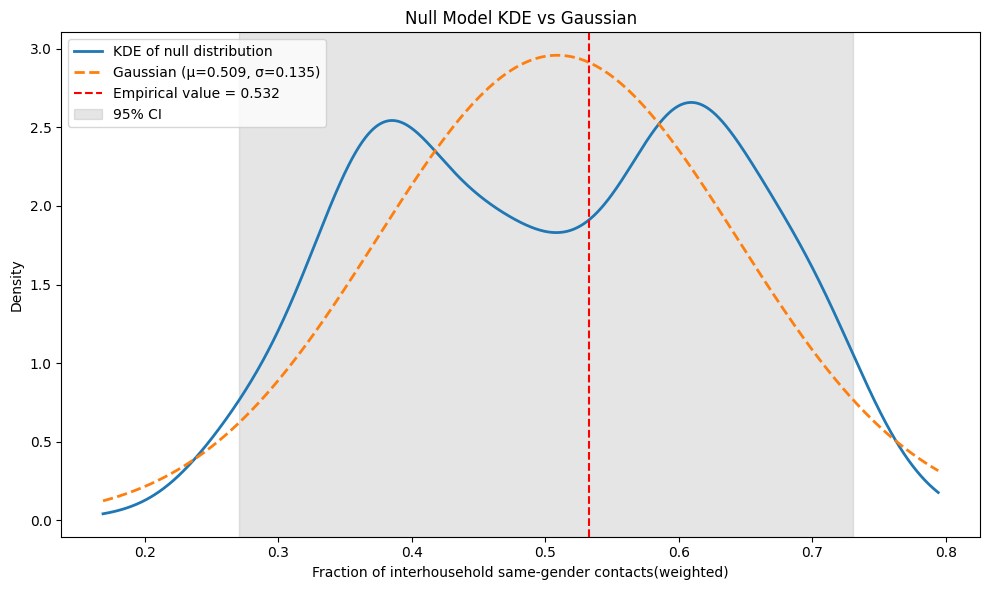

In [151]:
#for each null distribution we consider its mean and standard deviation to plot the gauss curve, in which we place the empirical value.
#If the empirical value is outside the 95% confidence interval of the null distribution,
#we can conclude that it is significantly different from what we would expect by chance.
# I plotted the kernel density estimate (KDE) of the null distribution based on its mean and standard deviation to be able to visually assess how well
# the central limit theorem approximates the null distribution to a normal one.
#Where needed, i calculated the p values in R, and it can be easily done by just using the pnorm(empirical_value, mean=mean(null), sd=sd(null)) function.
from scipy.stats import gaussian_kde
from scipy.stats import norm

mu= 0.5089100535212352 # type the mean you get
sigma= 0.13478758129614718 #type the standard deviation you get


kde = gaussian_kde(null_values_inter_gender)
x_vals = np.linspace(min(null_values_inter_gender), max(null_values_inter_gender), 1000)
y_kde = kde(x_vals)
y_gauss= norm.pdf(x_vals, loc=mu, scale=sigma)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_kde, label="KDE of null distribution", linewidth=2)
plt.plot(x_vals, y_gauss, label=f"Gaussian (μ={mu:.3f}, σ={sigma:.3f})", linestyle='--', linewidth=2)
plt.axvline(fraction_inter_gender, color='red', linestyle='--', label=f'Empirical value = {fraction_inter_gender:.3f}')
lower, upper = np.percentile(null_values_inter_gender, [2.5, 97.5])
plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.title("Null Model KDE vs Gaussian")
plt.xlabel("Fraction of interhousehold same-gender contacts(weighted)")
plt.ylabel("Density")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


### null distribution inter-household gender assortativity(unweighted)

In [152]:
#gender dictionary 
df_a_unw = df[['id1', 'gender1']].rename(columns={'id1': 'id', 'gender1': 'gender'})
df_b_unw = df[['id2', 'gender2']].rename(columns={'id2': 'id', 'gender2': 'gender'})
combined_df_unw = pd.concat([df_a_unw, df_b_unw], ignore_index=True)
unique_gender_df_unw = combined_df_unw.drop_duplicates(subset='id')
gender_dict_unw = dict(zip(unique_gender_df_unw['id'], unique_gender_df_unw['gender']))

# null model interhousehold same-gender contact fraction (unweighted)
null_values_inter_gender_unw = []

all_ids_unw = pd.concat([df['id1'], df['id2']]).unique()
original_genders_unw = gender_dict_unw

for i in range(1000):
    
    shuffled_unw = np.random.permutation(list(original_genders_unw.values()))
    shuffled_gender_map_unw = dict(zip(all_ids_unw, shuffled_unw))
    
    inter_df_unw = df[df['household'] == 'inter-household']
    
    gender1_shuffled_unw = inter_df_unw['id1'].map(shuffled_gender_map_unw)
    gender2_shuffled_unw = inter_df_unw['id2'].map(shuffled_gender_map_unw)

    same_gender_mask_unw = gender1_shuffled_unw == gender2_shuffled_unw

    inter_total_unw = len(inter_df_unw)
    inter_same_unw = same_gender_mask_unw.sum()

    null_value_inter_gender_unw = inter_same_unw / inter_total_unw if inter_total_unw > 0 else 0
    null_values_inter_gender_unw.append(null_value_inter_gender_unw)
#mean= 0.5083890339425587
#sd=0.038589627547717546


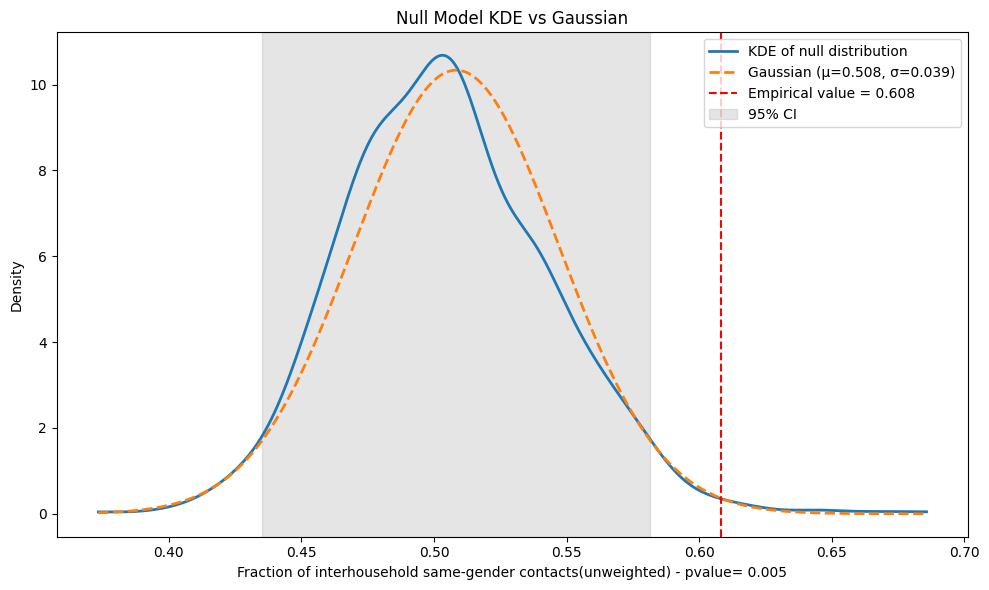

In [153]:
mu= 0.5083890339425587
sigma= 0.038589627547717546
#pvalue= 0.005172149
kde = gaussian_kde(null_values_inter_gender_unw)
x_vals = np.linspace(min(null_values_inter_gender_unw), max(null_values_inter_gender_unw), 1000)
y_kde = kde(x_vals)
y_gauss= norm.pdf(x_vals, loc=mu, scale=sigma)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_kde, label="KDE of null distribution", linewidth=2)
plt.plot(x_vals, y_gauss, label=f"Gaussian (μ={mu:.3f}, σ={sigma:.3f})", linestyle='--', linewidth=2)
plt.axvline(fraction_inter_gender_unw, color='red', linestyle='--', label=f'Empirical value = {fraction_inter_gender_unw:.3f}')
lower, upper = np.percentile(null_values_inter_gender_unw, [2.5, 97.5])
plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')

plt.title("Null Model KDE vs Gaussian")
plt.xlabel("Fraction of interhousehold same-gender contacts(unweighted) - pvalue= 0.005")
plt.ylabel("Density")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### null distribution for intra-household gender assortativity (weighted)

In [21]:
# null model interhousehold same-gender contact fraction 
null_values_intra_gender = []
all_ids = pd.concat([df['id1'], df['id2']]).unique()
original_genders = gender_dict


for i in range(1000):
    
    shuffled = np.random.permutation(list(original_genders.values()))
    shuffled_gender_map = dict(zip(all_ids, shuffled))
    
    gender1_shuffled = df['id1'].map(shuffled_gender_map)
    gender2_shuffled = df['id2'].map(shuffled_gender_map)

    # null model same-gender contact fraction 
    same_gender_mask = gender1_shuffled == gender2_shuffled
    intra_mask = df['household'] == 'intra-household'

    intra_total = df[intra_mask]['contact_event'].sum()
    intra_same = df[intra_mask & same_gender_mask]['contact_event'].sum()

    null_value_intra_gender= intra_same / intra_total if intra_total > 0 else 0
    null_values_intra_gender.append(null_value_intra_gender)

#mean= 0.507775613208177
#sd= 0.0695655254804712

   

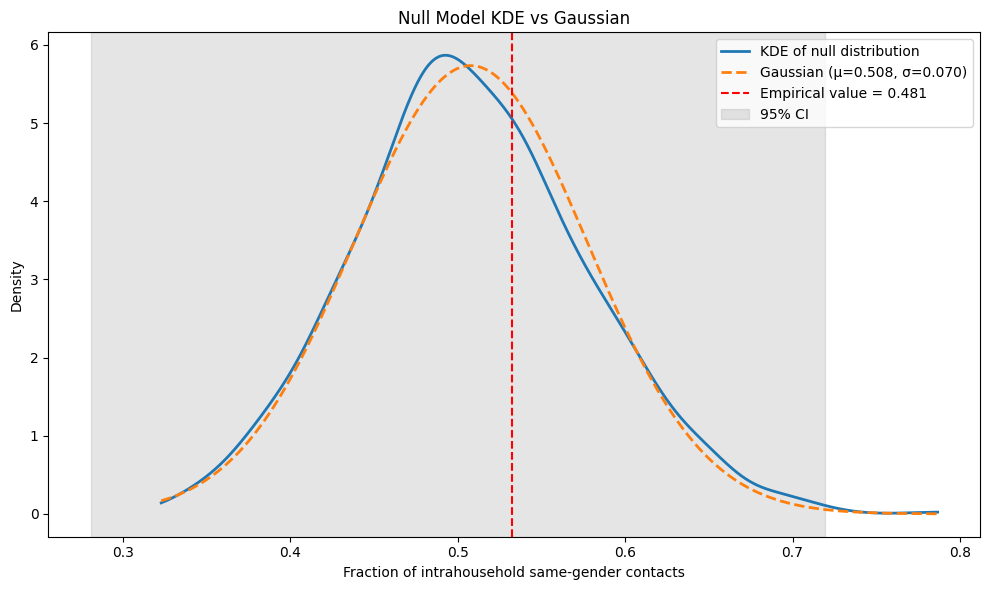

In [61]:
mu= 0.507775613208177
sigma= 0.0695655254804712

kde = gaussian_kde(null_values_intra_gender)
x_vals = np.linspace(min(null_values_intra_gender), max(null_values_intra_gender), 1000)
y_kde = kde(x_vals)
y_gauss= norm.pdf(x_vals, loc=mu, scale=sigma)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_kde, label="KDE of null distribution", linewidth=2)
plt.plot(x_vals, y_gauss, label=f"Gaussian (μ={mu:.3f}, σ={sigma:.3f})", linestyle='--', linewidth=2)
plt.axvline(fraction_inter_gender, color='red', linestyle='--', label=f'Empirical value = {fraction_intra_gender:.3f}')
lower, upper = np.percentile(null_values_inter_gender, [2.5, 97.5])
plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.title("Null Model KDE vs Gaussian")
plt.xlabel("Fraction of intrahousehold same-gender contacts(weighted)")
plt.ylabel("Density")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### null distribution for intrahousehold gender assortativity(unweighted)

In [155]:
null_values_intra_gender_unw = []
for i in range(1000):
    
    shuffled_unw = np.random.permutation(list(original_genders_unw.values()))
    shuffled_gender_map_unw = dict(zip(all_ids_unw, shuffled_unw))
    
    intra_df_unw = df[df['household'] == 'intra-household']
    
    gender1_shuffled_unw = intra_df_unw['id1'].map(shuffled_gender_map_unw)
    gender2_shuffled_unw = intra_df_unw['id2'].map(shuffled_gender_map_unw)

    same_gender_mask_unw = gender1_shuffled_unw == gender2_shuffled_unw

    intra_total_unw = len(intra_df_unw)
    intra_same_unw = same_gender_mask_unw.sum()

    null_value_intra_gender_unw = intra_same_unw / intra_total_unw if inter_total_unw > 0 else 0
    null_values_intra_gender_unw.append(null_value_intra_gender_unw)


#mean= 0.5060306258322237
#sd= 0.053936041767896556

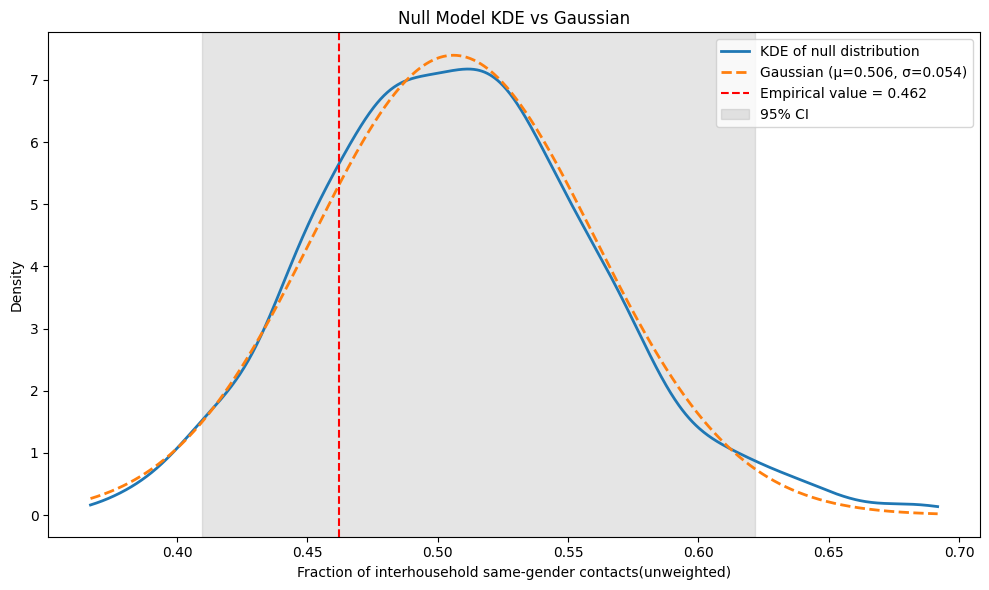

In [156]:
mu= 0.5060306258322237
sigma= 0.053936041767896556


kde = gaussian_kde(null_values_intra_gender_unw)
x_vals = np.linspace(min(null_values_intra_gender_unw), max(null_values_intra_gender_unw), 1000)
y_kde = kde(x_vals)
y_gauss= norm.pdf(x_vals, loc=mu, scale=sigma)
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_kde, label="KDE of null distribution", linewidth=2)
plt.plot(x_vals, y_gauss, label=f"Gaussian (μ={mu:.3f}, σ={sigma:.3f})", linestyle='--', linewidth=2)
plt.axvline(fraction_intra_gender_unw, color='red', linestyle='--', label=f'Empirical value = {fraction_intra_gender_unw:.3f}')
lower, upper = np.percentile(null_values_intra_gender_unw, [2.5, 97.5])
plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.title("Null Model KDE vs Gaussian")
plt.xlabel("Fraction of intrahousehold same-gender contacts(unweighted)")
plt.ylabel("Density")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


### null distribution for inter-household age assortativity (weighted)

In [157]:
# null model interhousehold same-age contact fraction 
null_values_inter_age = []

all_ids = pd.concat([df['id1'], df['id2']]).unique()
original_age =metadata

for i in range(1000):
    
    shuffled = np.random.permutation(list(original_age.values()))
    shuffled_age_map = dict(zip(all_ids, shuffled))
    
    age1_shuffled = df['id1'].map(shuffled_age_map)
    age2_shuffled = df['id2'].map(shuffled_age_map)

    # null model same-age contact fraction 
    same_age_mask = age1_shuffled == age2_shuffled
    inter_mask = df['household'] == 'inter-household'

    inter_total = df[inter_mask]['contact_event'].sum()
    inter_same = df[inter_mask & same_age_mask]['contact_event'].sum()

    null_value_inter_age= inter_same / inter_total if inter_total > 0 else 0
    null_values_inter_age.append(null_value_inter_age)

#mean= 0.38080967232682605
#sd= 0.1289487589742194

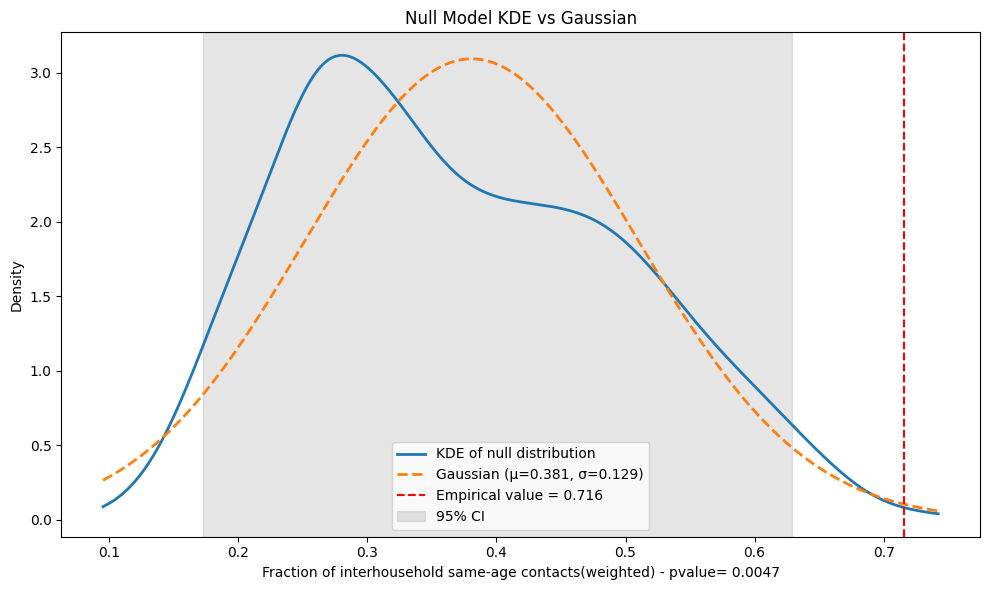

In [159]:
mu= 0.38080967232682605
sigma= 0.1289487589742194
#pvalue= 0.004703476

kde = gaussian_kde(null_values_inter_age)
x_vals = np.linspace(min(null_values_inter_age), max(null_values_inter_age), 1000)
y_kde = kde(x_vals)
y_gauss= norm.pdf(x_vals, loc=mu, scale=sigma) 

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_kde, label="KDE of null distribution", linewidth=2)
plt.plot(x_vals, y_gauss, label=f"Gaussian (μ={mu:.3f}, σ={sigma:.3f})", linestyle='--', linewidth=2)
plt.axvline(fraction_inter_age, color='red', linestyle='--', label=f'Empirical value = {fraction_inter_age:.3f}')
lower, upper = np.percentile(null_values_inter_age, [2.5, 97.5])
plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.title("Null Model KDE vs Gaussian")
plt.xlabel("Fraction of interhousehold same-age contacts(weighted) - pvalue= 0.0047")
plt.ylabel("Density")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### null distribution for inter-household age assortativity (unweighted)

In [162]:
# null model interhousehold same-age contact fraction 
null_values_inter_age_unw = []

all_ids = pd.concat([df['id1'], df['id2']]).unique()
original_age = metadata

for i in range(1000):
    
    shuffled = np.random.permutation(list(original_age.values()))
    shuffled_age_map = dict(zip(all_ids, shuffled))
    
    inter_df = df[df['household'] == 'inter-household']
    
    age1_shuffled = inter_df['id1'].map(shuffled_age_map)
    age2_shuffled = inter_df['id2'].map(shuffled_age_map)

    same_age_mask = age1_shuffled == age2_shuffled

    inter_total = len(inter_df)
    inter_same = same_age_mask.sum()

    null_value_inter_age = inter_same / inter_total if inter_total > 0 else 0
    null_values_inter_age_unw.append(null_value_inter_age)

#mean= 0.3740861618798956
#sd= 0.04322818068117592

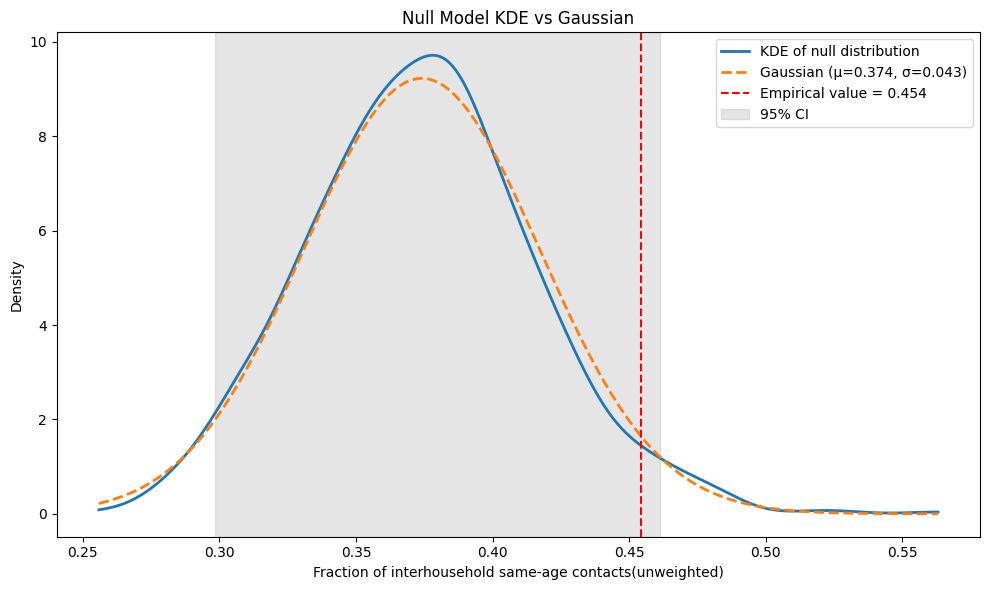

In [163]:
mu= 0.3740861618798956
sigma= 0.04322818068117592


kde = gaussian_kde(null_values_inter_age_unw)
x_vals = np.linspace(min(null_values_inter_age_unw), max(null_values_inter_age_unw), 1000)
y_kde = kde(x_vals)
y_gauss= norm.pdf(x_vals, loc=mu, scale=sigma) 
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_kde, label="KDE of null distribution", linewidth=2)
plt.plot(x_vals, y_gauss, label=f"Gaussian (μ={mu:.3f}, σ={sigma:.3f})", linestyle='--', linewidth=2)
plt.axvline(fraction_inter_age_unw, color='red', linestyle='--', label=f'Empirical value = {fraction_inter_age_unw:.3f}')
lower, upper = np.percentile(null_values_inter_age_unw, [2.5, 97.5])
plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.title("Null Model KDE vs Gaussian")
plt.xlabel("Fraction of interhousehold same-age contacts(unweighted)")
plt.ylabel("Density")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### null distribution for intra-household age assortativity (weighted)

In [29]:
null_values_intra_age = []
original_age =metadata


for i in range(1000):
    
    shuffled = np.random.permutation(list(original_age.values()))
    shuffled_age_map = dict(zip(all_ids, shuffled))
    
    age1_shuffled = df['id1'].map(shuffled_age_map)
    age2_shuffled = df['id2'].map(shuffled_age_map)

    # null model same-age contact fraction 
    same_age_mask = age1_shuffled == age2_shuffled
    intra_mask = df['household'] == 'intra-household'

    intra_total = df[intra_mask]['contact_event'].sum()
    intra_same = df[intra_mask & same_age_mask]['contact_event'].sum()

    null_value_intra_age= intra_same / intra_total if intra_total > 0 else 0
    null_values_intra_age.append(null_value_intra_age)

#mean= 0.37377789646562426
#sd= 0.06717001589326514



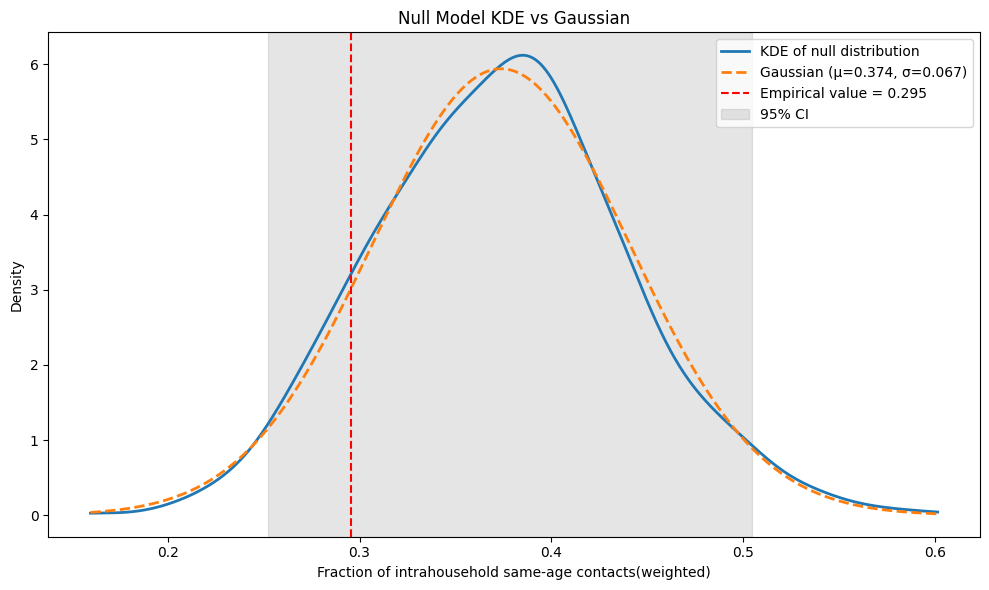

In [30]:
mu= 0.37377789646562426
sigma= 0.06717001589326514


kde = gaussian_kde(null_values_intra_age)
x_vals = np.linspace(min(null_values_intra_age), max(null_values_intra_age), 1000)
y_kde = kde(x_vals)
y_gauss= norm.pdf(x_vals, loc=mu, scale=sigma)
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_kde, label="KDE of null distribution", linewidth=2)
plt.plot(x_vals, y_gauss, label=f"Gaussian (μ={mu:.3f}, σ={sigma:.3f})", linestyle='--', linewidth=2)
plt.axvline(fraction_intra_age, color='red', linestyle='--', label=f'Empirical value = {fraction_intra_age:.3f}')
lower, upper = np.percentile(null_values_intra_age, [2.5, 97.5])
plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.title("Null Model KDE vs Gaussian")
plt.xlabel("Fraction of intrahousehold same-age contacts(weighted)")
plt.ylabel("Density")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

### null distribution for intra-household age assortativity (unweighted)

In [164]:
# null model interhousehold same-age contact fraction 
null_values_intra_age_unw = []

all_ids = pd.concat([df['id1'], df['id2']]).unique()
original_age = metadata

for i in range(1000):
    
    shuffled = np.random.permutation(list(original_age.values()))
    shuffled_age_map = dict(zip(all_ids, shuffled))
    
    intra_df = df[df['household'] == 'intra-household']
    
    age1_shuffled = intra_df['id1'].map(shuffled_age_map)
    age2_shuffled = intra_df['id2'].map(shuffled_age_map)

    same_age_mask = age1_shuffled == age2_shuffled

    intra_total = len(intra_df)
    intra_same = same_age_mask.sum()

    null_value_intra_age = intra_same / intra_total if intra_total > 0 else 0
    null_values_intra_age_unw.append(null_value_intra_age)

#mean= 0.37422037283621834
#sd= 0.0497092052366091

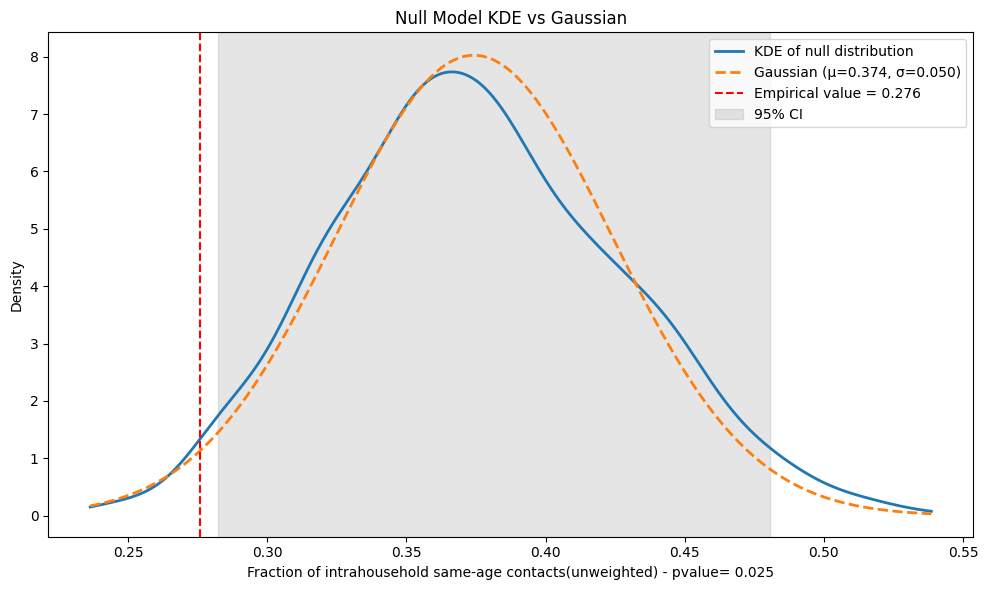

In [165]:
mu= 0.37422037283621834
sigma= 0.0497092052366091
# pvalue= 0.0249979


kde = gaussian_kde(null_values_intra_age_unw)
x_vals = np.linspace(min(null_values_intra_age_unw), max(null_values_intra_age_unw), 1000)
y_kde = kde(x_vals)
y_gauss= norm.pdf(x_vals, loc=mu, scale=sigma) 
plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_kde, label="KDE of null distribution", linewidth=2)
plt.plot(x_vals, y_gauss, label=f"Gaussian (μ={mu:.3f}, σ={sigma:.3f})", linestyle='--', linewidth=2)
plt.axvline(fraction_intra_age_unw, color='red', linestyle='--', label=f'Empirical value = {fraction_intra_age_unw:.3f}')
lower, upper = np.percentile(null_values_intra_age_unw, [2.5, 97.5])
plt.axvspan(lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.title("Null Model KDE vs Gaussian")
plt.xlabel("Fraction of intrahousehold same-age contacts(unweighted) - pvalue= 0.025")
plt.ylabel("Density")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

## daily activity profiles


### inferring households

In [ ]:
# I inferred myself the household structure of the graph with a dataset that provides the timestamps for each contact event between sensor ids, but 
# does not have both nodes' attributes and household ids. I changed dataset because the previous one did not have timestamps.
#In addition, this dataset was cleaned by Sociopatterns' scientists, restricting it to fewer days of analysis and 84 nodes(from 95), hence it is more reliable,
#even though the general structure of the graph is very similar to the previous one.
#Then, it is best to say that if we wanted to reproduce the previous sections with "perfect" accuracy, 
# we should infer both this dataset's nodes' attributes and household memberships, and then work with the 84 nodes.

In [2]:
gf= pd.read_csv(r"/Users/matteomedini/Downloads/tnet_malawi_pilot2.csv")

### general contact network

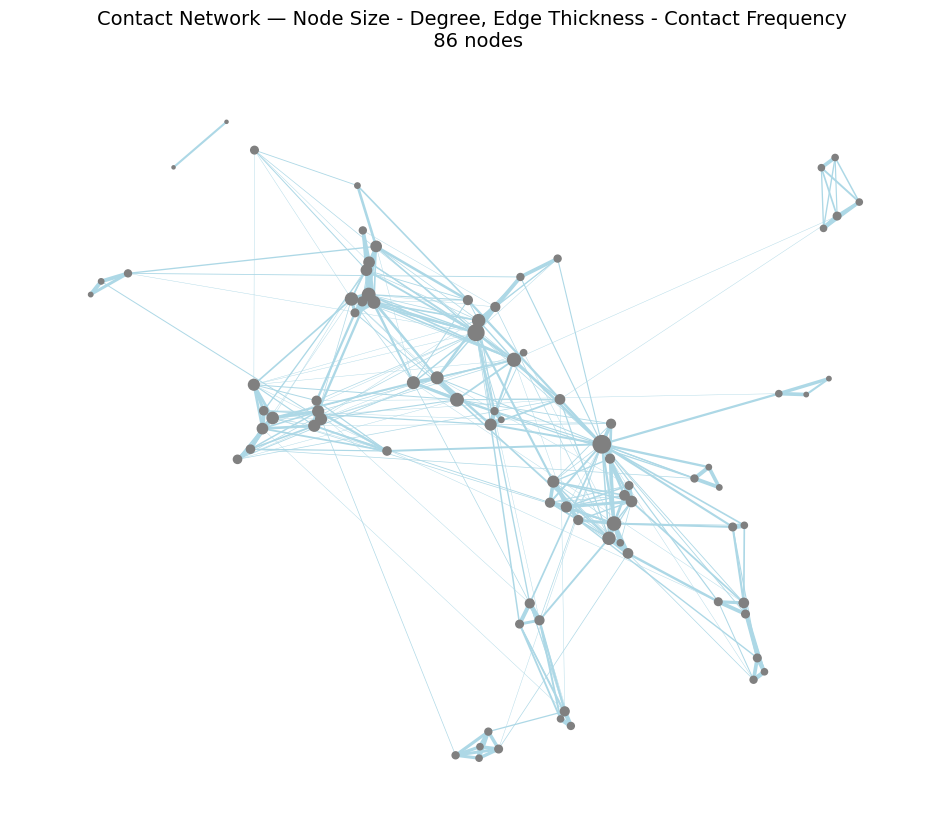

In [167]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

contact_counts = (
    gf.groupby([gf[['id1', 'id2']].min(axis=1), gf[['id1', 'id2']].max(axis=1)])
    .size()
    .reset_index(name='weight')
)
contact_counts.columns = ['id1', 'id2', 'weight']

Gfirst = nx.Graph()
Gfirst.add_weighted_edges_from(contact_counts.values)
pos = nx.spring_layout(Gfirst, seed=200, k=1.8, iterations=100)

weights = [np.log1p(Gfirst[u][v]['weight']) / np.log(10) for u, v in Gfirst.edges()]
sizes = [Gfirst.degree(n) * 5 for n in Gfirst.nodes()]

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(Gfirst, pos, width=weights, edge_color='lightblue', alpha=1)
nx.draw_networkx_nodes(Gfirst, pos, node_size=sizes, node_color='gray')
plt.title("Contact Network — Node Size - Degree, Edge Thickness - Contact Frequency \n 86 nodes", fontsize=14)
plt.axis('off')
plt.show()


In [4]:
gf['hours'] = (
    gf.groupby('day')['contact_time']
    .transform(lambda x: (x - x.iloc[0]) / 3600)
)
# this way we get each timestamp in hours from the first timestamp of the day

### building a graph for domestic contacts, to infer households

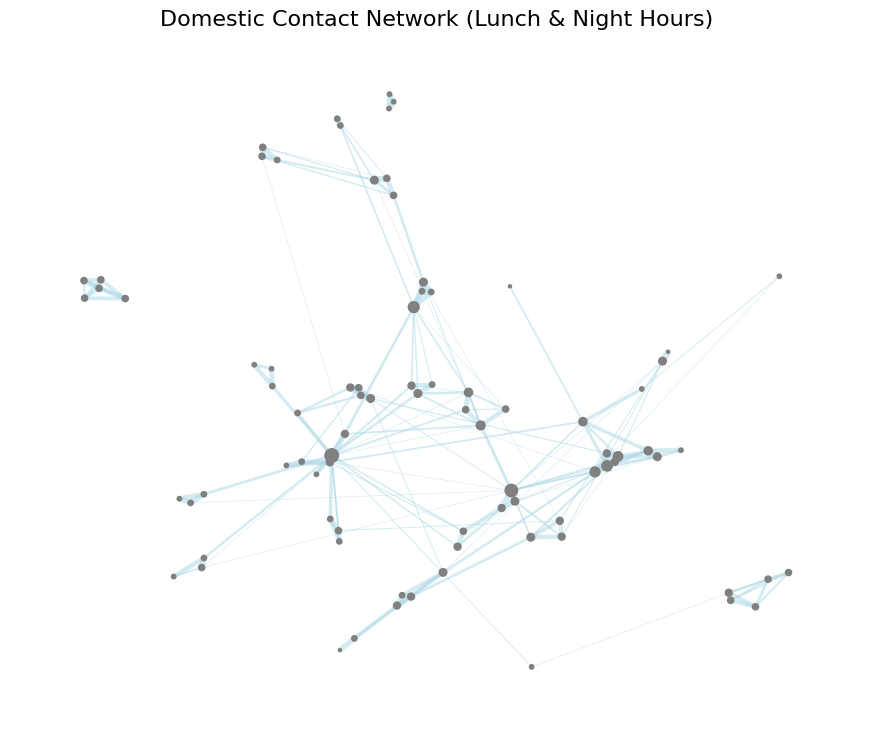

In [178]:
# it is written in the paper that household members are those who eat in the same kitchen and got to bed in the same house, so to run the louvain properly,
# I thought it is best to consider a graph that only includes contacts during lunch and night hours.
#However, since we are inferring the household structure, and given what the paper tells us about its size distribution, we need a significantly higher
#resolution parameter to better isolate household members. Logically, if during this time intervals in the day household members have stronger 
# intrahousehold contacts than interhousehold, keeping the resolution parameter higher than standard is not dangerous and will not split household members,
#rather it will help isolate all the households. Consider that the number of true households is 27 in this cleaned dataset and the nodes are 84, so we need 
# relatively small louvain communities to match the true family structure.

lunch = gf[(gf['hours'] >= 12.0) & (gf['hours'] < 14.0)]
night = gf[(gf['hours'] >= 19.0) | (gf['hours'] < 6.0)]
domestic_times = pd.concat([lunch, night])
domestic_times['pair'] = domestic_times.apply(lambda row: tuple(sorted([row['id1'], row['id2']])), axis=1)
edge_weights = domestic_times.groupby('pair').size().reset_index(name='weight')


G_domestic = nx.Graph()
for row in edge_weights.itertuples(index=False):
    id1, id2 = row.pair
    G_domestic.add_edge(id1, id2, weight=row.weight)


pos_domestic = nx.spring_layout(G_domestic, seed=200, k=1.3, iterations=100)
edge_weights_domestic = [np.log1p(G_domestic[u][v]['weight']) / np.log(5) for u, v in G_domestic.edges()]
node_sizes_domestic = [G_domestic.degree(n) * 5 for n in G_domestic.nodes()]
plt.figure(figsize=(11, 9))
nx.draw_networkx_edges(G_domestic, pos_domestic, width=edge_weights_domestic, edge_color='lightblue', alpha=0.5)
nx.draw_networkx_nodes(G_domestic, pos_domestic, node_size=node_sizes_domestic, node_color='gray')
plt.title("Domestic Contact Network (Lunch & Night Hours)", fontsize=16)
plt.axis('off')
plt.show()


In [73]:
# remove the 2 disconnected nodes (remove the 2 defective sensors' data)

nodes_gfirst = set(Gfirst.nodes)
nodes_gdomestic = set(G_domestic.nodes)
nodes_to_remove = nodes_gfirst - nodes_gdomestic
Gfirst.remove_nodes_from(nodes_to_remove)

### running the louvain

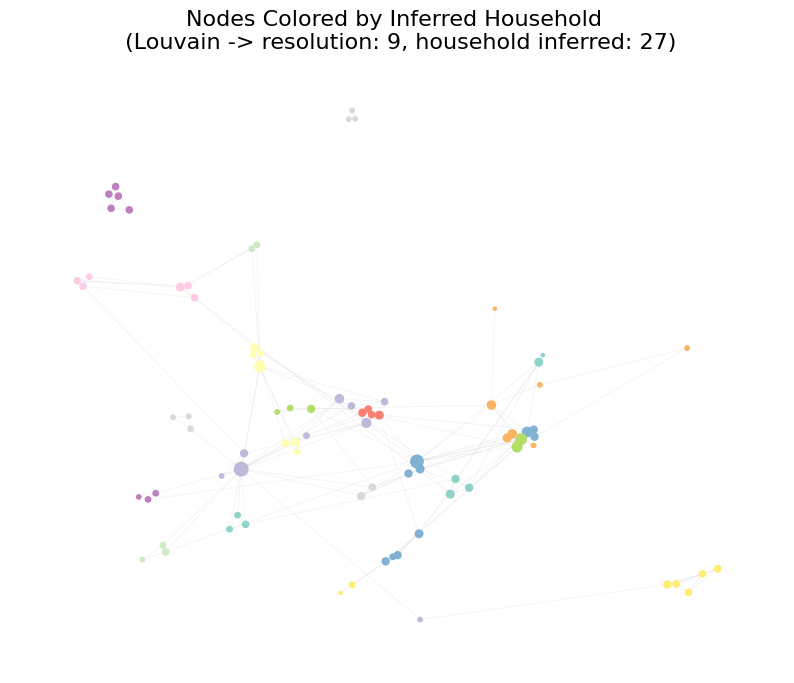

In [184]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community.community_louvain as community_louvain


partition_domestic = community_louvain.best_partition(G_domestic, weight='weight', resolution=9)
nx.set_node_attributes(G_domestic, partition_domestic, name='household_id')
domestic_pos = nx.spring_layout(G_domestic, seed=200, k=1, iterations=100)

domestic_household_ids = nx.get_node_attributes(G_domestic, 'household_id')
domestic_unique_households = sorted(set(domestic_household_ids.values()))

domestic_color_map = {hid: cm.Set3(i / len(domestic_unique_households)) for i, hid in enumerate(domestic_unique_households)}
domestic_node_colors = [domestic_color_map[domestic_household_ids[n]] for n in G_domestic.nodes()]

domestic_node_sizes = [G_domestic.degree(n) * 5 for n in G_domestic.nodes()]
domestic_edge_weights = [np.log1p(G_domestic[u][v]['weight']) / np.log(10) for u, v in G_domestic.edges()]


plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G_domestic, domestic_pos, edge_color='lightgray', width=0.5, alpha=0.3)
nx.draw_networkx_nodes(G_domestic, domestic_pos, node_color=domestic_node_colors, node_size=domestic_node_sizes)
plt.title("Nodes Colored by Inferred Household \n (Louvain -> resolution: 9, household inferred: 27)", fontsize=16)
plt.axis('off')
plt.show()


### household size distribution

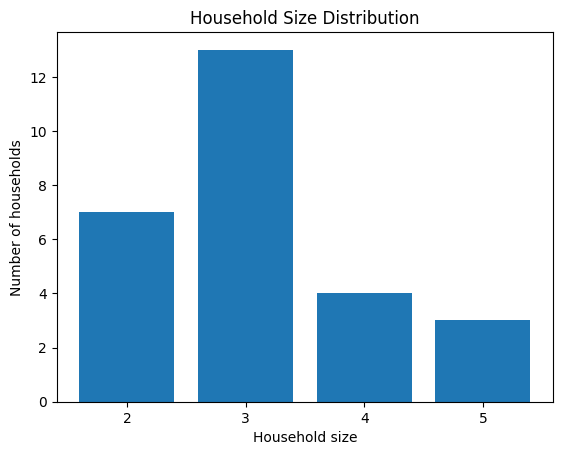

In [76]:
from collections import Counter

household_df = pd.DataFrame({
    'node_id': list(partition_domestic.keys()),
    'household_id': list(partition_domestic.values())
})

household_df = household_df.sort_values(by='household_id').reset_index(drop=True)
sizes = Counter(partition_domestic.values())
household_size_counts = Counter(sizes.values())

x = list(household_size_counts.keys())
y = list(household_size_counts.values())

plt.bar(x, y)
plt.xlabel('Household size')
plt.ylabel('Number of households')
plt.title('Household Size Distribution')
plt.xticks(sorted(x))  
plt.show()
# the household size distribution matches the paper's

In [77]:
# adding household membership to the original dataframe
gf['hh_id1'] = gf['id1'].map(partition_domestic)
gf['hh_id2'] = gf['id2'].map(partition_domestic)
gf['household'] = gf.apply(lambda row: 'intra-household' if row['hh_id1'] == row['hh_id2'] else 'inter-household', axis=1)


###  aggregated pmfs & cmfs

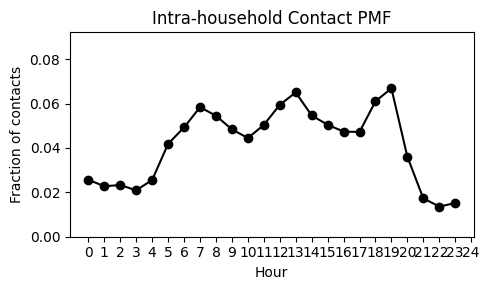

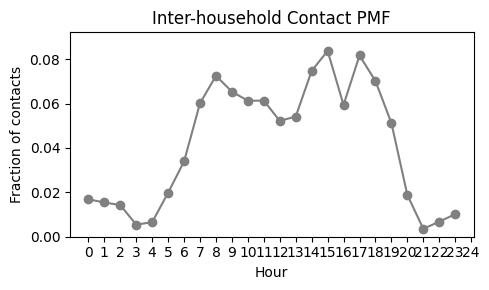

In [91]:
import matplotlib.pyplot as plt
import numpy as np

bins = np.arange(0, 25, 1)

intra = gf[gf['household'] == 'intra-household']
inter = gf[gf['household'] == 'inter-household']

intra_hist, _ = np.histogram(intra['hours'], bins=bins)
inter_hist, _ = np.histogram(inter['hours'], bins=bins)

intra_pmf = intra_hist / intra_hist.sum()
inter_pmf = inter_hist / inter_hist.sum()

ymax = max(intra_pmf.max(), inter_pmf.max()) * 1.1

plt.figure(figsize=(5, 3))
plt.plot(bins[:-1], intra_pmf, '-o', color='black')
plt.xticks(bins)
plt.xlabel('Hour')
plt.ylabel('Fraction of contacts')
plt.title('Intra-household Contact PMF')
plt.ylim(0, ymax)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(bins[:-1], inter_pmf, '-o', color='gray')
plt.xticks(bins)
plt.xlabel('Hour')
plt.ylabel('Fraction of contacts')
plt.title('Inter-household Contact PMF')
plt.ylim(0, ymax)
plt.tight_layout()
plt.show()


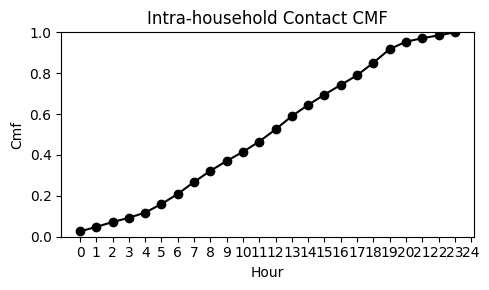

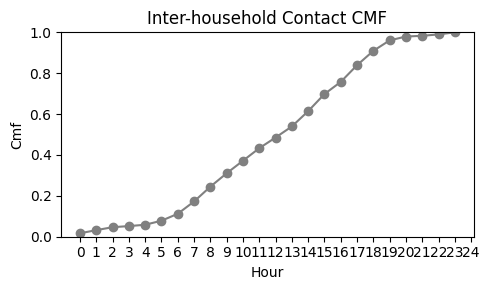

In [101]:
# aggregated cdfs
intra_cmf = np.cumsum(intra_pmf)
inter_cmf = np.cumsum(inter_pmf)



plt.figure(figsize=(5, 3))
plt.plot(bins[:-1], intra_cmf, '-o', color='black')
plt.xticks(bins)
plt.xlabel('Hour')
plt.ylabel('Cmf')
plt.title('Intra-household Contact CMF')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(bins[:-1], inter_cmf, '-o', color='gray')
plt.xticks(bins)
plt.xlabel('Hour')
plt.ylabel('Cmf')
plt.title('Inter-household Contact CMF')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


### ks distances intrahousehold

In [102]:
# following the paper's work, for each household, I will calculate the minimum Kolmogorov-Smirnov distance between the intra-household contact CMF and the global intra-household contact CMF.
# I shuffled the origin of times of the cmfs for 100 times, and i took the minimum ks distance for each household.
#I did the same for inter-household contacts, but I used the inter-household contact CMF instead, and took the minimum ks distance for each individual

bins = np.arange(0, 25, 1)
household_ids = gf['hh_id1'].unique()

results = []

for hid in household_ids:
    subset = gf[(gf['household'] == 'intra-household') & (gf['hh_id1'] == hid) & (gf['hh_id2'] == hid)]
    if len(subset) == 0:
        continue

    hist_hh, _ = np.histogram(subset['hours'], bins=bins)
    pmf_hh = hist_hh / hist_hh.sum()
    cdf_hh = np.cumsum(pmf_hh)

    ks_values = []

    for _ in range(100):
        shift = np.random.randint(0, 24)
        cdf_hh_shifted = np.roll(cdf_hh, -shift)
        cdf_global_shifted = np.roll(intra_cmf, -shift)
        ks = np.max(np.abs(cdf_hh_shifted - cdf_global_shifted))
        ks_values.append(ks)

    min_ks = min(ks_values)
    results.append({'household_id': hid, 'min_ks': min_ks})

ks_df = pd.DataFrame(results).sort_values(by='min_ks', ascending=False).reset_index(drop=True)


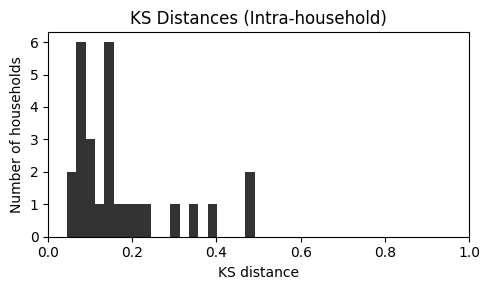

In [103]:
plt.figure(figsize=(5, 3))
plt.hist(ks_df['min_ks'], bins=20, color='black', alpha=0.8)
plt.xlim(0, 1)
plt.xlabel('KS distance')
plt.ylabel('Number of households')
plt.title('KS Distances (Intra-household)')
plt.tight_layout()
plt.show()


### ks distances interhousehold

In [107]:
bins = np.arange(0, 25, 1)
individual_ids = pd.unique(gf[['id1', 'id2']].values.ravel())

results_inter = []

for pid in individual_ids:
    subset = gf[
        (gf['household'] == 'inter-household') &
        ((gf['id1'] == pid) | (gf['id2'] == pid))
    ]
    if len(subset) == 0:
        continue

    hist_ind, _ = np.histogram(subset['hours'], bins=bins)
    if hist_ind.sum()==0:
        continue
    pmf_ind = hist_ind / hist_ind.sum()
    cdf_ind = np.cumsum(pmf_ind)

    ks_values = []
    for _ in range(100):
        shift = np.random.randint(0, 24)
        cdf_ind_shifted = np.roll(cdf_ind, -shift)
        cdf_global_shifted = np.roll(inter_cmf, -shift)
        ks = np.max(np.abs(cdf_ind_shifted - cdf_global_shifted))
        ks_values.append(ks)

    min_ks = min(ks_values)
    results_inter.append({'individual_id': pid, 'min_ks': min_ks})
    
ks_df_inter = pd.DataFrame(results_inter).sort_values(by='min_ks', ascending=False).reset_index(drop=True)

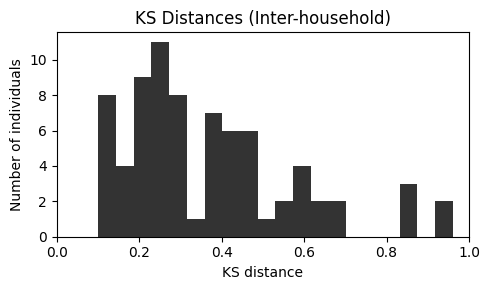

In [108]:
plt.figure(figsize=(5, 3))
plt.hist(ks_df_inter['min_ks'], bins=20, color='black', alpha=0.8)
plt.xlim(0, 1)
plt.xlabel('KS distance')
plt.ylabel('Number of individuals')
plt.title('KS Distances (Inter-household)')
plt.tight_layout()
plt.show()

## intrahousehold null model for contact matrix

In [194]:
# this is the null model that makes us able to statistically assess wether some of the 6 cells of the contact matrix we built show
#significantly more or less contacts than expected by chance, given the household structure and the age distribution of the population.
# Since we are talking about an intrahousehold null model, we will shuffle the age labels of the individuals in each household, and after getting the 
# 6 null distributions(adults- adults, adults-adolescents, adults-children, adolescents-adolescents, adolescents-children, children-children), wre will
# use the same formula to compute each cell of the null matrix(not drawn here), and from there we use the same logic as the assortativity section
#to compute the p-values of each cell of the contact matrix.
from collections import defaultdict
id_age_map = all_meta.set_index('id')['age_group']
ids = id_age_map.index.to_numpy()

# arrays to store the null distribution of each cell
null_cell1 = []
null_cell2 = []
null_cell3 = []
null_cell4 = []
null_cell5 = []
null_cell6 = []

df['day'] = pd.to_datetime(df['day'])

df_participation = pd.DataFrame({
    'id': pd.concat([df['id1'], df['id2']]),
    'day': pd.concat([df['day'], df['day']])
}).drop_duplicates()

person_days = df_participation.groupby('id')['day'].apply(set).to_dict()

household_to_ids = defaultdict(list)
for id_, hh in household_dict.items():
    household_to_ids[hh].append(id_)

for _ in range(100):
   
    shuffled_map = {}
    for hh_ids in household_to_ids.values():
        labels = [id_age_map.get(i, None) for i in hh_ids]
        if None in labels:
            continue  
        np.random.shuffle(labels)
        for i, label in zip(hh_ids, labels):
            shuffled_map[i] = label

    df['age1_shuf'] = df['id1'].map(shuffled_map)
    df['age2_shuf'] = df['id2'].map(shuffled_map)

    adults = [i for i, age in shuffled_map.items() if age == 'adults']
    adolescents = [i for i, age in shuffled_map.items() if age == 'adolescents']
    children = [i for i, age in shuffled_map.items() if age == 'children']

    num_adults = len(adults)
    num_adolescents = len(adolescents)
    num_children = len(children)

    adult_days = [len(person_days.get(i, set())) for i in adults]
    adolescent_days = [len(person_days.get(i, set())) for i in adolescents]
    child_days = [len(person_days.get(i, set())) for i in children]

    mean_overlap_adults = np.mean(adult_days)
    mean_overlap_adolescents = np.mean(adolescent_days)
    mean_overlap_children = np.mean(child_days)
    mean_overlap_adults_adolescents = np.mean(adult_days + adolescent_days)
    mean_overlap_adults_children = np.mean(adult_days + child_days)
    mean_overlap_adolescents_children = np.mean(adolescent_days + child_days)

    # Cell 1: adult–adult
    duration = df[
        (df['household'] == 'intra-household') &
        (df['age1_shuf'] == 'adults') & (df['age2_shuf'] == 'adults')
    ]['seconds'].sum()

    val = (duration / mean_overlap_adults) / num_adults
    null_cell1.append(val)

    # Cell 2: adult–adolescent
    duration = df[
        (df['household'] == 'intra-household') &
        (
            ((df['age1_shuf'] == 'adults') & (df['age2_shuf'] == 'adolescents')) |
            ((df['age1_shuf'] == 'adolescents') & (df['age2_shuf'] == 'adults'))
        )
    ]['seconds'].sum()

    val = (2 * duration / mean_overlap_adults_adolescents) / (num_adults + num_adolescents)
    null_cell2.append(val)

    # Cell 3: adult–child
    duration = df[
        (df['household'] == 'intra-household') &
        (
            ((df['age1_shuf'] == 'adults') & (df['age2_shuf'] == 'children')) |
            ((df['age1_shuf'] == 'children') & (df['age2_shuf'] == 'adults'))
        )
    ]['seconds'].sum()

    val = (2 * duration / mean_overlap_adults_children) / (num_adults + num_children)
    null_cell3.append(val)

    # Cell 4: adolescent–adolescent
    duration = df[
        (df['household'] == 'intra-household') &
        (df['age1_shuf'] == 'adolescents') & (df['age2_shuf'] == 'adolescents')
    ]['seconds'].sum()

    val = (duration / mean_overlap_adolescents) / num_adolescents
    null_cell4.append(val)

    # Cell 5: adolescent–child
    duration = df[
        (df['household'] == 'intra-household') &
        (
            ((df['age1_shuf'] == 'adolescents') & (df['age2_shuf'] == 'children')) |
            ((df['age1_shuf'] == 'children') & (df['age2_shuf'] == 'adolescents'))
        )
    ]['seconds'].sum()

    val = (2 * duration / mean_overlap_adolescents_children) / (num_adolescents + num_children)
    null_cell5.append(val)

    # Cell 6: child–child
    duration = df[
        (df['household'] == 'intra-household') &
        (df['age1_shuf'] == 'children') & (df['age2_shuf'] == 'children')
    ]['seconds'].sum()

    val = (duration / mean_overlap_children) / num_children
    null_cell6.append(val)

null_cell1 = np.array(null_cell1)
null_cell2 = np.array(null_cell2)
null_cell3 = np.array(null_cell3)
null_cell4 = np.array(null_cell4)
null_cell5 = np.array(null_cell5)
null_cell6 = np.array(null_cell6)



In [197]:
#these are the values I got first
#null_cell1(adult) u = 623.5031621774834 , sd= 86.98677568442336
#null_cell2 (adult-adolescent)   u= 1532.1725435786461  sd= 123.29208361362195
#null_cell3(adult-children)   u= 1598.1277946695898   sd= 169.89195296471203
#null_cell4(adolescent)     u= 599.7940312668932 sd= 151.3286505701111
#null_cell5(adolescent-children) u= 638.7566064151489 sd= 152.2910652757263
#null_cell6(children)     u=183.89840487006427    sd= 196.6436470305338




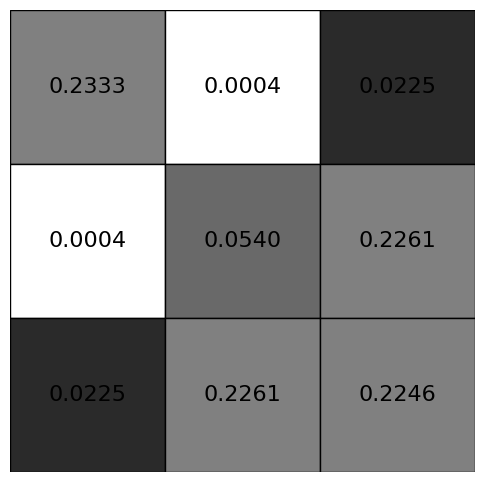

In [214]:
from matplotlib.patches import Rectangle
# You will draw a pvalues matrix with each empirical cell's pvalue, considering the correspondent null distribution just computed. 
# Again, the null distribution determines the two parameters of the gaussian , and the p value is the probability of getting a value that is at least as extreme
# as the empirical, under the H0(null distribution) hypothesis. The p values were computed in R.
intrapvaluecellone= 0.2333#gray
intrapvaluecelltwo=0.0004 #empirical smaller than by chance #white
intrapvaluecellthree=0.0225 #empirical bigger than by chance #black
intrapvaluecellfour= 0.054 #empirical bigger #dark gray
intrapvaluecellfive= 0.2261 #gray
intrapvaluecellsix=0.2246 #gray

intra_pvalues_matrix = pd.DataFrame({
    'adults':      [intrapvaluecellone, intrapvaluecelltwo, intrapvaluecellthree],
    'adolescents': [intrapvaluecelltwo, intrapvaluecellfour, intrapvaluecellfive],
    'children':    [intrapvaluecellthree, intrapvaluecellfive, intrapvaluecellsix]
}, index=['adults', 'adolescents', 'children'])

color_matrix = [
    ['gray', 'white', '#2a2a2a'],
    ['white', 'dimgray', 'gray'],
    ['#2a2a2a', 'gray', 'gray']
]

fig, ax = plt.subplots(figsize=(6, 6))

ax.axis('off')
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)


for i in range(3):        
    for j in range(3):   
        x = j
        y = 2 - i  

       
        color = color_matrix[i][j]

  
        val = intra_pvalues_matrix.iloc[i, j]

        
        rect = Rectangle((x, y), 1, 1, facecolor=color, edgecolor='black')
        ax.add_patch(rect)

      
        ax.text(x + 0.5, y + 0.5, f"{val:.4f}", color='black', ha='center', va='center', fontsize=16)

plt.show()